## Imports

In [6]:
import sys
import os
sys.path.insert(0, os.path.abspath('/home/eli/projects/ner-german-telegram/src'))

In [7]:
import pandas as pd
import numpy as np
import torch
from datasets import load_from_disk
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score
from collections import Counter, defaultdict
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification 
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from datasets import load_dataset, Dataset, load_metric, DatasetDict
from collections import Counter, defaultdict
import seaborn as sns
from matplotlib import pyplot as plt

## Model

In [8]:
model_name = 'deepset/gbert-base'

## Dataset

In [9]:
dataset_name = 'smartdata'

## Tokenizer

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name) # more params defined in method tokenize_and_align_labels()

## Data collator

In [11]:
data_collator = DataCollatorForTokenClassification(tokenizer)

## Training params

In [12]:
NUM_EPOCHS = 10
BATCH_SIZE = 2
LOGGING_STRATEGY='epoch'
OUTPUT_DIR = f'../../../../../models/{model_name}-{dataset_name}-{NUM_EPOCHS}_epochs'
OVERWRITE_OUTPUT_DIR = True # only for first experiments
LOG_LEVEL = 'error'
EVALUATION_STRATEGY = 'epoch'
SAVE_STRATEGY ='epoch'
WEIGHT_DECAY = 0.01 # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
CALLBACK = EarlyStoppingCallback(early_stopping_patience=3)
LOAD_BEST_MODEL_AT_END = True,
METRIC_FOR_BEST_MODEL='eval_loss'

## Check GPU and set up torch device

In [13]:
# check gpu
torch.cuda.is_available()

True

In [14]:
# create torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load dataset

In [15]:
ds = load_from_disk(f'/home/eli/data/data_prepared_for_tf/{dataset_name}/')

In [16]:
ds

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_str'],
        num_rows: 1861
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_str'],
        num_rows: 230
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_str'],
        num_rows: 228
    })
})

## Methods

In [17]:
def get_indices_and_tags(ds, split='train', tag_name='ner_tags'):
    tags = ds[split].features[tag_name].feature
    #id2label param for model
    index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
    # label2id param for model
    tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
    
    return tags, index2tag, tag2index


def ner_tags_str2id(ner_tags_str):
    
    tag_ids = []

    for tag in ner_tags_str:         
        idx = tag2index[tag]
        tag_ids.append(int(idx))
        
    return tag_ids


def tokenize_and_align_labels(examples):
    
    tokenized_inputs = tokenizer(
        examples['tokens'], 
        padding='max_length',
        truncation=True, 
        is_split_into_words=True
    )    
    
    labels = []
    
    for idx, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else: 
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs


def encode_dataset(corpus, columns_to_remove=['ner_tags', 'tokens', 'ner_tags_str']):
    return corpus.map(tokenize_and_align_labels, 
                      batched=True,
                      remove_columns=columns_to_remove)

In [18]:
# Evaluation

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)
        
    return preds_list, labels_list    


def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    return {'f1': f1, 
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy}


def get_training_history(trainer):
    df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_accuracy']]
    df = df.rename(columns={"epoch":"epoch",
                            "loss": "training_loss", 
                            "eval_loss": "validation_loss", 
                            "eval_f1":"f1", 
                            "eval_precision": "precision",
                           'eval_recall': 'recall', 
                            'eval_accuracy': 'accuracy'})
    df['epoch'] = df["epoch"].apply(lambda x: round(x))
    df['training_loss'] = df["training_loss"].ffill()
    df[['validation_loss', 'f1']] = df[['validation_loss', 'f1']].bfill().ffill()
    df.drop_duplicates()
    
    return df

In [19]:
tags, index2tag, tag2index = get_indices_and_tags(ds)

In [20]:
ds_encoded = encode_dataset(ds)

Parameter 'function'=<function tokenize_and_align_labels at 0x7f620416ec10> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.47ba/s]


## model initialization and config

In [21]:
model_config = AutoConfig.from_pretrained(model_name, 
                                        num_labels=tags.num_classes, 
                                        id2label=index2tag,
                                        label2id=tag2index)

In [22]:
model = AutoModelForTokenClassification.from_pretrained(model_name, config=model_config).to(device)

Some weights of the model checkpoint at deepset/gbert-base were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at deepset/gb

## Training

In [23]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR, 
    overwrite_output_dir=OVERWRITE_OUTPUT_DIR, 
    log_level=LOG_LEVEL, 
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE, 
    evaluation_strategy=EVALUATION_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    weight_decay=WEIGHT_DECAY,
    logging_strategy=LOGGING_STRATEGY,
    disable_tqdm=False,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    metric_for_best_model=METRIC_FOR_BEST_MODEL)

In [24]:
trainer = Trainer(
    model=model, 
    args=training_args,
    data_collator=data_collator, 
    compute_metrics=compute_metrics,
    train_dataset=ds_encoded['train'],
    eval_dataset=ds_encoded['test'],
    tokenizer=tokenizer,
    callbacks=[CALLBACK])

In [25]:
%time
trainer.train()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


/home/eli/envs/bt/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=5586, training_loss=0.07489301378992438, metrics={'train_runtime': 1188.8071, 'train_samples_per_second': 15.654, 'train_steps_per_second': 7.831, 'total_flos': 2917929745926144.0, 'train_loss': 0.07489301378992438, 'epoch': 6.0})

In [26]:
trainer.evaluate()

{'eval_loss': 0.11144900321960449,
 'eval_f1': 0.8535078153398764,
 'eval_precision': 0.82328190743338,
 'eval_recall': 0.8860377358490567,
 'eval_accuracy': 0.9688923141596021,
 'eval_runtime': 5.2697,
 'eval_samples_per_second': 43.646,
 'eval_steps_per_second': 21.823,
 'epoch': 6.0}

In [27]:
eval_df = get_training_history(trainer)

In [28]:
eval_df

epoch  training_loss  validation_loss        f1  precision    recall  \
0       1         0.1971         0.114647  0.835350        NaN       NaN   
1       1         0.1971         0.114647  0.835350   0.812411  0.859623   
2       2         0.1000         0.129571  0.851865        NaN       NaN   
3       2         0.1000         0.129571  0.851865   0.818942  0.887547   
4       3         0.0668         0.111449  0.853508        NaN       NaN   
5       3         0.0668         0.111449  0.853508   0.823282  0.886038   
6       4         0.0445         0.128773  0.859222        NaN       NaN   
7       4         0.0445         0.128773  0.859222   0.829354  0.891321   
8       5         0.0260         0.134608  0.854419        NaN       NaN   
9       5         0.0260         0.134608  0.854419   0.830956  0.879245   
10      6         0.0150         0.165049  0.858604        NaN       NaN   
11      6         0.0150         0.165049  0.858604   0.832153  0.886792   
12      6         0.0150         0.111449  0.853508        NaN       NaN   
13      6         0.0150         0.111449  0.853508   0.823282  0.886038   

    accuracy  
0        NaN  
1   0.968472  
2        NaN  
3   0.967631  
4        NaN  
5   0.968892  
6        NaN  
7   0.968962  
8        NaN  
9   0.968822  
10       NaN  
11  0.969453  
12       NaN  
13  0.968892

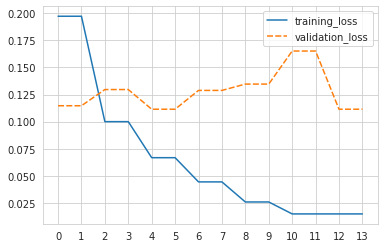

In [29]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['training_loss', 'validation_loss']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()

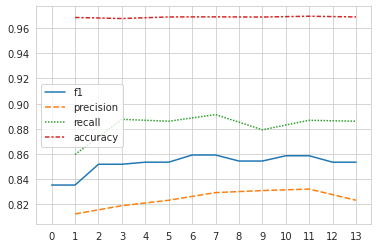

In [30]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['f1', 'precision', 'recall', 'accuracy']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()

In [31]:
trainer.create_model_card()